# 1. Non-stiff instance $\mu = 1$

## 1.1. Model description

In [1]:
using ReachabilityAnalysis, BenchmarkTools, Plots

┌ Info: Precompiling ReachabilityAnalysis [1e97bd63-91d1-579d-8e8d-501d2b57c93f]
└ @ Base loading.jl:1260


In [35]:
@taylorize function vdp!(dx, x, params, t)
    local μ = 1.0
    dx[1] = x[2]
    dx[2] = (μ * x[2]) * (1 - x[1]^2) - x[1]
    return dx
end

## 1.2. Reachability settings

In [36]:
X0 = Hyperrectangle(low=[1.25, 2.35], high=[1.55, 2.45]) # initial condition
prob = @ivp(x' = vdp!(x), dim=2, x(0) ∈ X0) # initial-value problem
T = 7.0; # time horizon

## 1.3. Results

In [37]:
sol = solve(prob, T=T, alg=TMJets(abs_tol=1e-10, orderT=10, orderQ=2));

In [38]:
solz = overapproximate(sol, Zonotope);

In [39]:
support_function([0.0, 1.0], solz) # specification requires this to be smaller than 2.75

2.7383767960440695

In [40]:
# measure combined runtime
function run_and_check(prob, T)
    sol = solve(prob, T=T, alg=TMJets(abs_tol=1e-10, orderT=10, orderQ=2))
    solz = overapproximate(sol, Zonotope)
    @assert support_function([0.0, 1.0], solz) < 2.75
end

@benchmark run_and_check($prob, $T)

BenchmarkTools.Trial: 
  memory estimate:  299.09 MiB
  allocs estimate:  4843140
  --------------
  minimum time:     220.043 ms (18.97% GC)
  median time:      262.135 ms (21.47% GC)
  mean time:        269.737 ms (21.51% GC)
  maximum time:     433.519 ms (22.64% GC)
  --------------
  samples:          19
  evals/sample:     1

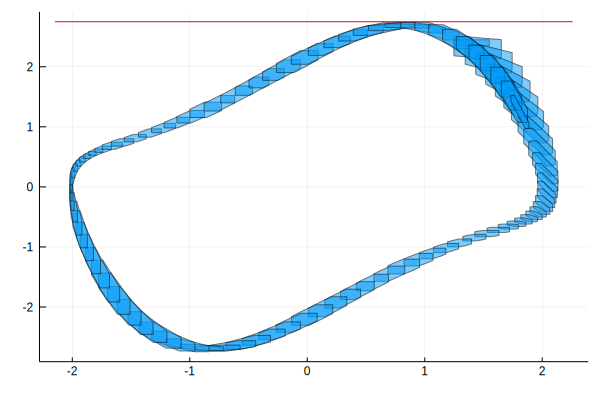

In [41]:
plot(solz, vars=(1, 2))
plot!(x -> 2.75, color=:red, lab="")

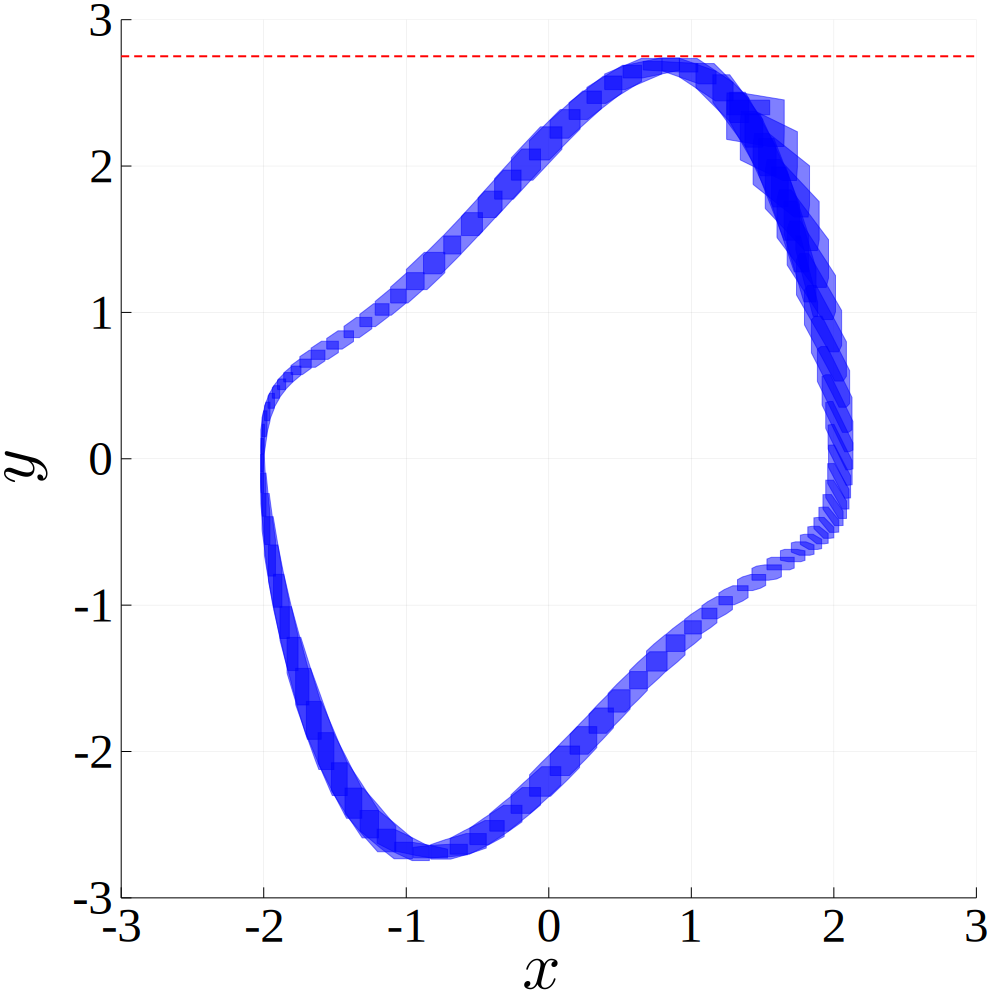

In [42]:
# publication-ready plot

using LaTeXStrings, Plots, Plots.PlotMeasures, LaTeXStrings

plot(solz, vars=(1, 2),
     tickfont=font(30, "Times"), guidefontsize=45,
     xlab=L"x\raisebox{-0.5mm}{\textcolor{white}{.}}",
     ylab=L"y\raisebox{2mm}{\textcolor{white}{.}}",
     xtick=[-3., -2., -1., 0., 1., 2., 3.], ytick=[-3., -2., -1., 0., 1., 2., 3.],
     xlims=(-3., 3.), ylims=(-3., 3.),
     bottom_margin=6mm, left_margin=2mm, right_margin=4mm, top_margin=3mm,
     size=(1000, 1000), linecolor="blue", color="blue")

plot!(x->x, x->2.75, -3., 3., line=2, color="red", linestyle=:dash, legend=nothing)

# 2. Stiff instance ($\mu = 2$)

In [26]:
using Revise, ReachabilityAnalysis
using BenchmarkTools, Plots

## 2.1. Model description

In [27]:
@taylorize function vdp_stiff!(dx, x, params, t)
    local μ = 2.0
    dx[1] = x[2]
    dx[2] = (μ * x[2]) * (1 - x[1]^2) - x[1]
    return dx
end

## 2.2. Reachability settings

In [28]:
X0 = Hyperrectangle(low=[1.55, 2.35], high=[1.85, 2.45]) # initial condition
radius(X0)

0.1499999999999999

With this initial set, the property $y(t) < 4.0$ for all $t \in [0, T]$ is violated. Further tweaking the `TMJets` parameters did not help to satisfy the property. So the strategy is to **split** the initial states along the $x$-direction.

In [29]:
X0s = split(X0, [8, 1]); # vector of initial sets
@show radius(X0s[1])

prob = @ivp(x' = vdp_stiff!(x), dim=2, x(0) ∈ X0s) # initial-value problem
T = 8.0; # time horizon

radius(X0s[1]) = 0.04999999999999982


## 2.3. Results

In [30]:
sol = solve(prob, T=T, alg=TMJets(abs_tol=1e-10, orderT=8, orderQ=2));

In [31]:
solz = overapproximate(sol, Zonotope);

In [32]:
support_function([0.0, 1.0], solz) # the specification states that this should be < 4.0

3.982322873155003

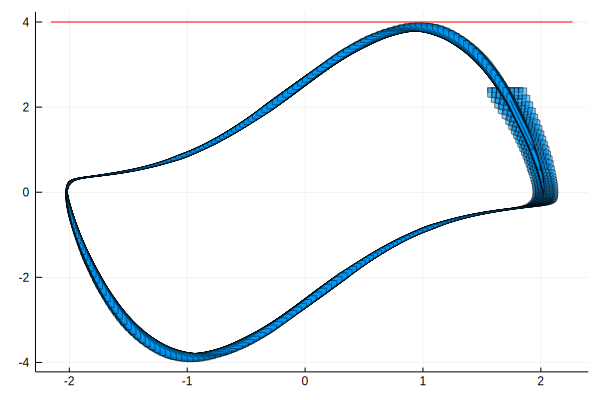

In [33]:
plot(solz, vars=(1, 2))
plot!(x -> 4.0, color=:red, lab="")

In [24]:
# measure combined runtime
function run_and_check(prob, T)
    sol = solve(prob, T=T, alg=TMJets(abs_tol=1e-10, orderT=8, orderQ=2))
    solz = overapproximate(sol, Zonotope)
    @assert support_function([0.0, 1.0], solz) < 4.0
end

@benchmark run_and_check($prob, $T)

BenchmarkTools.Trial: 
  memory estimate:  3.37 GiB
  allocs estimate:  57166907
  --------------
  minimum time:     4.654 s (19.41% GC)
  median time:      5.032 s (20.78% GC)
  mean time:        5.032 s (20.78% GC)
  maximum time:     5.409 s (21.96% GC)
  --------------
  samples:          2
  evals/sample:     1

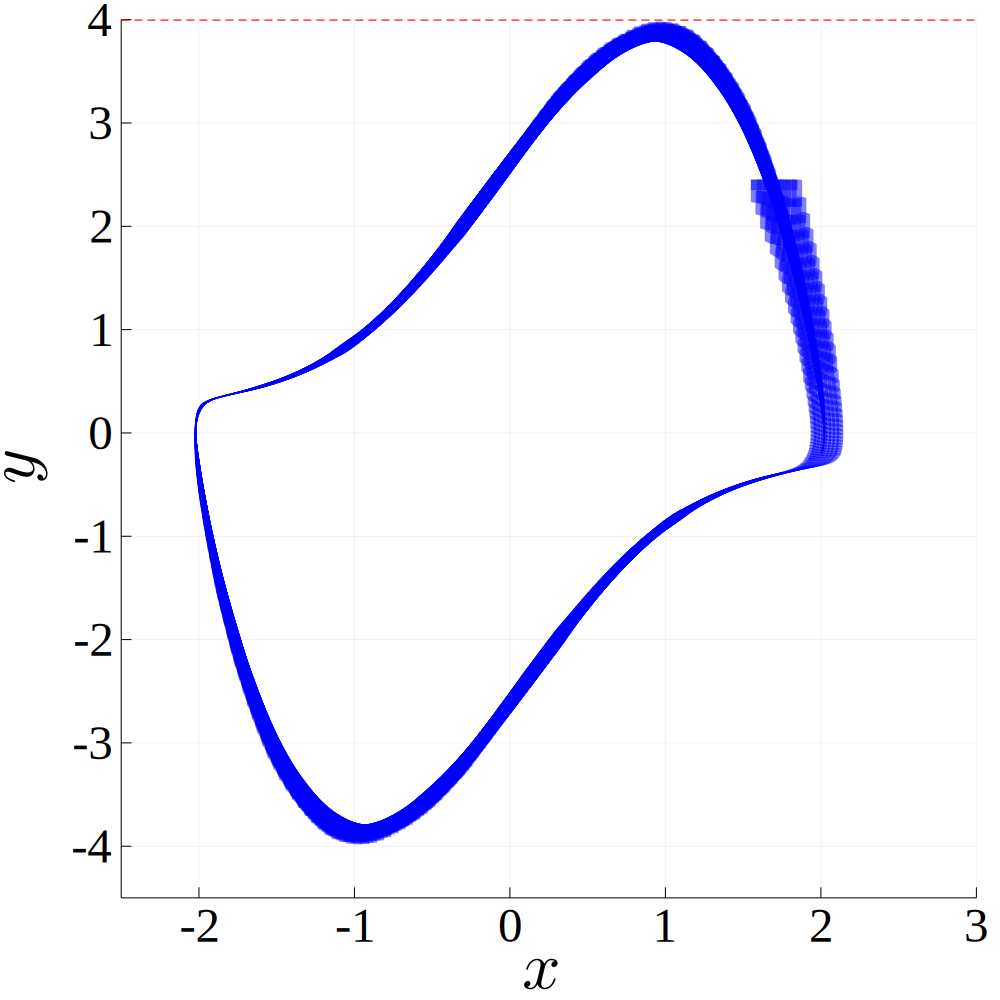

In [34]:
# publication-ready plot

using LaTeXStrings, Plots, Plots.PlotMeasures, LaTeXStrings

plot(solz, vars=(1, 2),
     tickfont=font(30, "Times"), guidefontsize=45,
     xlab=L"x\raisebox{-0.5mm}{\textcolor{white}{.}}",
     ylab=L"y\raisebox{2mm}{\textcolor{white}{.}}",
     xtick=[-2., -1., 0., 1., 2., 3.], ytick=[-4., -3., -2., -1., 0., 1., 2., 3., 4.],
     xlims=(-2.5, 3.), ylims=(-4.5, 4.),
     bottom_margin=6mm, left_margin=2mm, right_margin=4mm, top_margin=3mm,
     size=(1000, 1000), color="blue", linewidth=0.0, linecolor="blue", alpha=.5)

plot!(x->x, x->4.0, -3., 3., line=2, color="red", linestyle=:dash, legend=nothing)